# NYC Yellow Taxi Rides

## I. Overview

### 1. Abstract

Using **data science** techniques and the open dataset from NYC's TLC, we've managed to discover some interesting insights in the way the Yellow Taxicabs operated in the first month of the year 2019.

### 2. Keywords

nyc, taxi, yellow-taxi, tlc, data-engineering, data-analysis

### 3. Introduction

NYC is popular for many things. One of these things is the yellow taxicab. They are widely recognizable symbols of the city. Taxis painted yellow (medallion taxis) are able to pick up passengers anywhere in the five boroughs. Taxicabs are operated by private companies and licensed by the New York City Taxi and Limousine Commission (TLC).

Luckily for us, [TLC Trip Record Data](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page) is an open dataset which we can use to gain some interesting insights on how people in NYC use them.

We are going to use a Data Science workflow to achieve our goals.

**Data Acquisition --> Data Exploration --> Data Pre-processing --> Analysis**


### 4. Project Objectives

The objective of this project is to apply *data science* techniques to discover useful insights in the data provided by NYC's TLC (Taxi & Limousine Commision) for the month of January 2019.

## II. The Data

### 1. Source
[TLC Trip Record Data](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

We are going to use the trip record data starting from January 2019. We are also going to use the Taxi Zone Lookup Table also provided by this source.

### 2. Description
**A. TRIPS DATA**
- **Files**: yellow_tripdata_2019-01.csv (header included)
- **Summary**: Each record models a yellow taxi trip.

|**Column**|**Description**|
|---|---|
|VendorID|A code indicating the TPEP provider that provided the record. **<ul><li>1= Creative Mobile Technologies, LLC;</li> <li>2= VeriFone Inc. </li></ul>**|
|tpep_pickup_datetime|The date and time when the meter was engaged.|
|tpep_dropoff_datetime|The date and time when the meter was disengaged.|
|passenger_count|The number of passengers in the vehicle. This is a driver-entered value.|
|trip_distance|The elapsed trip distance in miles reported by the taximeter.|
|RatecodeID|The final rate code in effect at the end of the trip. **<ul><li>1=Standard rate</li> <li>2=JFK</li> <li>3=Newark</li> <li>4=Nassau or Westchester</li><li>5=Negotiated fare</li> <li>6=Group ride</li></ul>**|
|store_and_fwd_flag|This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server. **<ul><li>Y=store and forward trip</li><li>N=not a store and forward trip</li></ul>**|
|PULocationID|TLC Taxi Zone in which the taximeter was engaged|
|DOLocationID|TLC Taxi Zone in which the taximeter was disengaged|
|payment_type|A numeric code signifying how the passenger paid for the trip. **<ul><li>1=Credit card</li><li>2=Cash</li><li>3=No charge</li><li>4=Dispute</li><li>5=Unknown</li><li>6=Voided trip</li></ul>**|
|fare_amount|The time-and-distance fare calculated by the meter.|
|extra|Miscellaneous extras and surcharges.  Currently, this only includesthe 0.50 and 1 rush hour and overnight charges.|
|mta_tax|0.50 MTA tax that is automatically triggered based on the metered rate in use.|
|tip_amount|This field is automatically populated for credit card tips. Cash tips are not included.|
|tolls_amount|Total amount of all tolls paid in trip.|
|improvement_surcharge|0.30 improvement surcharge assessed trips at the flag drop.|
|total_amount|The total amount charged to passengers. Does not include cash tips.|
|congestion_surcharge|Surcharge in the case of congestion.|

- **Details**:
For further details please refer to the [trip record user guide](https://www1.nyc.gov/assets/tlc/downloads/pdf/trip_record_user_guide.pdf) and the [yellow trips data dictionary](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf), both provided by TLC.

**B. TAXI ZONE LOOKUP TABLE**
- **Files**: taxi+_zone_lookup.csv (header included)
- **Summary**: Each record models a taxi zone.

|**Column**|**Description**|
|---|---|
|"LocationID"|ID of the location|
|"Borough"|Borough in which the taxi zone is located|
|"Zone"|Name of the zone|
|"service_zone"|Type of zone, irrelevant for the yellow taxicabs as these are not restricted|

- **Details**: For further details please refer to the [trip record user guide](https://www1.nyc.gov/assets/tlc/downloads/pdf/trip_record_user_guide.pdf) provided by TLC. Maps of the taxi zones for each borough can be found [here](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

## III. The Environment

On the current environment, only spark is installed so we need to also install the other tools.

In [1]:
%pip install matplotlib
%pip install seaborn

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%%bash
apt-get install --assume-yes wget

Reading package lists...
Building dependency tree...
Reading state information...
wget is already the newest version (1.20.1-1.1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


## IV. Data Acquisition

First we need to download the data. We are going to simply use wget to download the necessary csv files in a new directory called *nyc-taxi-data*.

This might take a while as the total size of the data is over 600MB.

In [3]:
%%bash
# in case you already have the data, it's of no use to download it again.
if [ ! -d nyc-taxi-data ]
then
    mkdir nyc-taxi-data
    wget -nv -P nyc-taxi-data https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-01.csv
    wget -nv -P nyc-taxi-data https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv
fi

## V. Data Exploration

After we acquired the data, we need to get familiar with it, identify missing values, trends, outliers and check the veridicity of the documentation. This can help us understand the data better so that we know what alterations are needed in the next phase of Data Pre-Processing.

Please note that there are other data exploration objectives like finding correlations between variabes. However, in this chapter we focus mainly on techniques that help us understand how we can clean and improve the data that we have.

Before anything else, let's import the packages that we need and create the connection to the spark cluster.

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession

In [5]:
spark = SparkSession.\
        builder.\
        appName("nyc-taxi-app").\
        master("spark://spark-master:7077").\
        config("spark.executor.memory", "1g").\
        getOrCreate()

First let's read the trips data from the csv trip file in a DataFrame. 

In [6]:
trips = spark.read.csv('nyc-taxi-data/yellow_tripdata_2019-01.csv', header=True, inferSchema=True)

First, let's have a look at the metadata.

In [7]:
print(f'Columns: {len(trips.columns)}')

Columns: 18


In [8]:
print(f'Rows: {trips.count()}')

Rows: 7667792


In [9]:
trips.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)



So it looks like there were **7.6 MILION** yellow taxi trips in NYC in the first month of 2019.

We can already see that the columns **extra**, **mta_tax**,**tolls_amount** and **improvement_surcharge** can be dropped later in the pre-processing stage as they do not provide much information for us and won't be useful for our purpose. 

Let's make use of the describe() function and identify if we have missing values and where they are.

In [10]:
trips.describe().show()

+-------+------------------+--------------------+---------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+---------------------+-----------------+--------------------+
|summary|          VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|   passenger_count|     trip_distance|        RatecodeID|store_and_fwd_flag|     PULocationID|      DOLocationID|       payment_type|       fare_amount|             extra|            mta_tax|        tip_amount|      tolls_amount|improvement_surcharge|     total_amount|congestion_surcharge|
+-------+------------------+--------------------+---------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-------------------+------------------+------------------+-------------------+--------------

We can see that the only column with missing values seem to be **congestion_surcharge** which was to be expected as not all trips suffer congestion. There seem to be almost 3M rows which have non-missing values for this row but we need to check how many of these are equal to 0.

However, the **min** and **max** summaries give us more valuable information. There seem to be rows with corrupted values, e.g. datetimes out of January 2019, negative or unrealistic amounts, invalid RatecodeIDs etc. These outliers need to be removed.

Let's test some of our assumptions to see if they are true so that we know how to proceed next.
First, let's check if there is a considerable amount of 0.0 in the congestion_surcharge column.

In [11]:
trips.filter('congestion_surcharge = 0.0').count()

2811777

It looks like most of the rows have congestion_surcharge equal to 0 so we can also drop this column.

Now, we know from the documentation provided by TLC that there are only 2 possible VendorID values, 1 and 2. However, before considering any different value an outlier, let's see weather or not there are other legitimate VendorIDs which were simply not documented.

In [12]:
trips.groupBy('VendorID').count().collect()

[Row(VendorID=1, count=2938778),
 Row(VendorID=4, count=76823),
 Row(VendorID=2, count=4652191)]

Looks like there is another Vendor with the ID of 4. Even if it accounts for only less than 0.01% of the data, we will still keep these observations as it is unrealistic to assume that 76823 rows are corrupted only because the VendorID differs.

Now, let's do the same with the RatecodeID.

In [13]:
trips.groupBy('RatecodeID').count().collect()

[Row(RatecodeID=1, count=7430139),
 Row(RatecodeID=6, count=46),
 Row(RatecodeID=3, count=11801),
 Row(RatecodeID=5, count=54569),
 Row(RatecodeID=4, count=4895),
 Row(RatecodeID=2, count=166090),
 Row(RatecodeID=99, count=252)]

There seems to be another RatecodeID=99. Since we don't know what this means and the number of rows with this RatecodeID is fairly low, we can simply modify these observations in the Pre-Processing stage to Unknown=5.

Finally, let's check how many rows we will need to drop because they have negative or unrealistic amount values. 

In [14]:
trips.filter('fare_amount < 0.0 or fare_amount > 100000.0 or tip_amount < 0.0 or total_amount < 0.0 or total_amount > 200000.0').count()

7133

## VI. Data Pre-Processing

**Assumptions**:
- There is another undocumented vendor with the VendorID of 4 which reported ~77000 trips.
- The RatecodeID=99 is Unknown.
- The fare_amount is in the range [0.0, 100000] and the total_amount in the range [0.0, 200000]. The rest of the values are corrupted / outliers.

**Clean & Transform Steps**:
1. Drop extra, mta_tax, tolls_amount, improvement_surcharge, congestion_surcharge columns;
2. Drop duplicates if they exist;
3. Switch type of datetime columns to timestamp;
4. Remove outlier rows: datetimes outside January 2019 | negative or unrealistcly high amounts | 0 trip_distance or passenger_count;
5. Modify RatecodeID=99 to 5 (Unknown);
6. Integrate with the taxi zone lookup table to add 2 new columns: PUBorough and DOBorough;
7. Add a new column based on pickup_datetime: day_of_week (integer numbers from 1=Monday to 7=Sunday).

In [15]:
# 1. Drop extra, mta_tax,tolls_amount and improvement_surcharge columns
trips = trips.drop('extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge')
trips.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)



In [16]:
# 2. Drop duplicates if they exist
trips = trips.dropDuplicates()

In [17]:
# 3. Switch type of datetime columns to timestamp
from pyspark.sql.functions import col, to_timestamp
trips = trips.withColumn('tpep_pickup_datetime', to_timestamp(col('tpep_pickup_datetime'), 'yyyy-MM-dd HH:mm:ss'))
trips = trips.withColumn('tpep_dropoff_datetime', to_timestamp(col('tpep_dropoff_datetime'), 'yyyy-MM-dd HH:mm:ss'))
trips.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)



In [18]:
# 4. Remove outlier rows: datetimes outside Jan 2019 | negative or unrealistcly high amounts | 0 trip_distance or passenger_count
from pyspark.sql.functions import unix_timestamp
start_timestamp = '2019-01-01 00:00:00'
end_timestamp = '2019-07-01 00:00:00'
trips_clean_1 = trips.filter((trips['tpep_pickup_datetime'] >= start_timestamp) &
             (trips['tpep_pickup_datetime'] < end_timestamp) &
             (trips['tpep_dropoff_datetime'] >= start_timestamp) &
             (trips['tpep_dropoff_datetime'] < end_timestamp) &
             (trips['trip_distance'] > 0.0) & (trips['passenger_count'] > 0) &
             (trips['fare_amount'] >= 0.0) & (trips['fare_amount'] <= 100000.0) &
             (trips['total_amount'] >= 0.0) & (trips['total_amount'] <= 200000.0))
trips_clean_1.count()

7491271

In [20]:
# 5. Modify RatecodeID=99 to 5 (Unknown)
from pyspark.sql.functions import when
trips_clean_2 = trips_clean_1.withColumn('RatecodeID', when(col('RatecodeID') == 99, 5).otherwise(col('RatecodeID')))
trips_clean_2.filter(col('RatecodeID') == 99).count()

0

In [21]:
# 6. Integrate with the taxi zone lookup table to add 2 new columns: PUBorough and DOBorough
# first, let's create the new DF for the lookup table
lookupDF = spark.read.csv('nyc-taxi-data/taxi+_zone_lookup.csv', header=True, inferSchema=True)
lookupDF.printSchema()

root
 |-- LocationID: integer (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Zone: string (nullable = true)
 |-- service_zone: string (nullable = true)



In [22]:
lookupDF = lookupDF.drop('Zone', 'service_zone')
lookupDF.printSchema()

root
 |-- LocationID: integer (nullable = true)
 |-- Borough: string (nullable = true)



In [23]:
# replace PULocationID with PUBorough
trips_clean_3 = trips_clean_2.\
                join(lookupDF, trips_clean_2.\
                PULocationID == lookupDF.LocationID).\
                withColumnRenamed('Borough', 'PUBorough').\
                drop('PULocationID', 'LocationID')
trips_clean_3.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- PUBorough: string (nullable = true)



In [24]:
# replace DOLocationID with DOBorough
trips_clean_4 = trips_clean_3.\
                join(lookupDF, trips_clean_3.DOLocationID == lookupDF.LocationID).\
                withColumnRenamed('Borough', 'DOBorough').\
                drop('DOLocationID', 'LocationID')
trips_clean_4.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- PUBorough: string (nullable = true)
 |-- DOBorough: string (nullable = true)



In [25]:
# 7. Add a new column based on pickup_datetime: day_of_week (integer numbers from 1=Monday to 7=Sunday)
from pyspark.sql.functions import dayofweek
trips_final = trips_clean_4.withColumn('day_of_week', dayofweek(col('tpep_pickup_datetime')))
trips_final.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- PUBorough: string (nullable = true)
 |-- DOBorough: string (nullable = true)
 |-- day_of_week: integer (nullable = true)



In [26]:
# Cleanup
trips.unpersist()
trips_clean_1.unpersist()
trips_clean_2.unpersist()
trips_clean_3.unpersist()
trips_clean_4.unpersist()
trips_final.cache()

DataFrame[VendorID: int, tpep_pickup_datetime: timestamp, tpep_dropoff_datetime: timestamp, passenger_count: int, trip_distance: double, RatecodeID: int, store_and_fwd_flag: string, payment_type: int, fare_amount: double, tip_amount: double, total_amount: double, PUBorough: string, DOBorough: string, day_of_week: int]

In the end, let's have a look a glimpse of our data before diving into the analytics.

In [27]:
trips_final.head(5)

[Row(VendorID=2, tpep_pickup_datetime=datetime.datetime(2019, 1, 1, 0, 38), tpep_dropoff_datetime=datetime.datetime(2019, 1, 1, 0, 43, 44), passenger_count=1, trip_distance=0.81, RatecodeID=1, store_and_fwd_flag='N', payment_type=2, fare_amount=5.5, tip_amount=0.0, total_amount=6.8, PUBorough='Manhattan', DOBorough='Manhattan', day_of_week=3),
 Row(VendorID=1, tpep_pickup_datetime=datetime.datetime(2019, 1, 1, 0, 21, 41), tpep_dropoff_datetime=datetime.datetime(2019, 1, 1, 0, 26, 23), passenger_count=1, trip_distance=1.1, RatecodeID=1, store_and_fwd_flag='N', payment_type=1, fare_amount=5.5, tip_amount=2.0, total_amount=8.8, PUBorough='Manhattan', DOBorough='Manhattan', day_of_week=3),
 Row(VendorID=2, tpep_pickup_datetime=datetime.datetime(2019, 1, 1, 0, 21, 25), tpep_dropoff_datetime=datetime.datetime(2019, 1, 1, 0, 31, 44), passenger_count=5, trip_distance=0.98, RatecodeID=1, store_and_fwd_flag='N', payment_type=1, fare_amount=8.0, tip_amount=2.79, total_amount=12.09, PUBorough='Man

## VII. Analysis

After succesfully cleaning the data and bringing it in a usable form, we can finally do some analytics on it.

Before that, let's prepare the visualization tools.

In [28]:
%matplotlib inline
sns.set(style="darkgrid")

def plot(x, y, ax, title, y_label):
    ax.set_title(title)
    ax.set_ylabel(y_label)
    ax.bar(x, y)

Let's start with the simplest of analytics and create some rankings!

In [29]:
trips_final.createOrReplaceTempView('trips')
top_trips_pickup_location = spark.sql('SELECT PUBorough, COUNT(*) as cnt FROM trips GROUP BY PUBorough ORDER BY cnt DESC')
top_trips_dropoff_location = spark.sql('SELECT DOBorough, COUNT(*) as cnt FROM trips GROUP BY DOBorough ORDER BY cnt DESC')

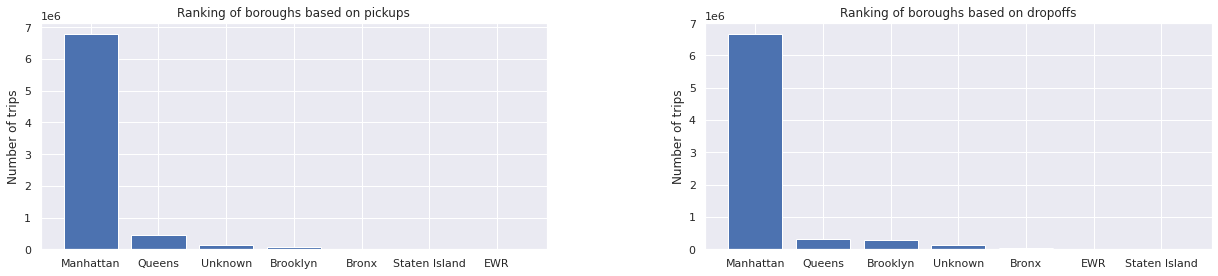

In [30]:
# now let's visualize the results
fig, (ax1, ax2) = plt.subplots(ncols=2)
pandasDF1 = top_trips_pickup_location.toPandas()
pandasDF2 = top_trips_dropoff_location.toPandas()
plot(pandasDF1.PUBorough, pandasDF1.cnt, ax1, 'Ranking of boroughs based on pickups', 'Number of trips')
plot(pandasDF2.DOBorough, pandasDF2.cnt, ax2, 'Ranking of boroughs based on dropoffs', 'Number of trips')
fig.tight_layout()
fig.set_size_inches(20, 4)

It looks like most of the yellow taxicabs clients are in the Manhattan area. It's probably not so surprising since probably most of the people from other boroughs use other transportation means.

Now let's see which days of the week are the busiest.

In [31]:
top_busy_days = spark.sql('SELECT day_of_week, COUNT(*) as cnt FROM trips GROUP BY day_of_week ORDER BY day_of_week')

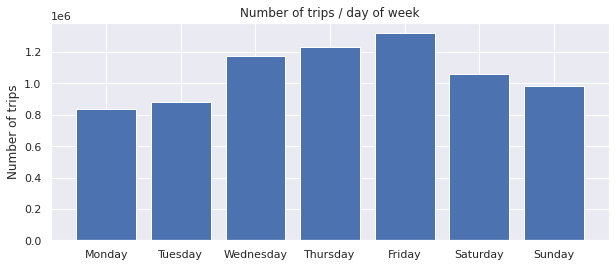

In [32]:
fig, ax = plt.subplots()
pandasDF1 = top_busy_days.toPandas()
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plot(days_of_week, pandasDF1.cnt, ax, "Number of trips / day of week", "Number of trips")
fig.set_size_inches(10, 4)

Even though we would maybe expect the weekend to have the smallest number of trips, we can see that actually Monday and Tuesday are the days in which new yorkers travel the least by yellow taxicabs while Friday are the busiest days.

Finally, let's see what people prefer to use between cash and credit card and which ratecodes are the most popular (excepting the standard one).

In [33]:
payment_types = spark.sql('SELECT payment_type, COUNT(*) as cnt FROM trips GROUP BY payment_type HAVING payment_type IN (1, 2) ORDER BY payment_type')
ratecodes = spark.sql('SELECT RatecodeID, COUNT(*) as cnt FROM trips GROUP BY RatecodeID HAVING RatecodeID != 1 ORDER BY RatecodeID')

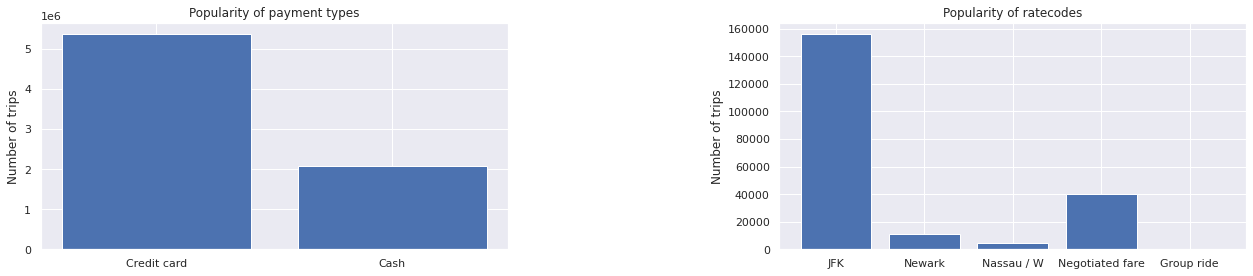

In [34]:
# now let's visualize the results
fig, (ax1, ax2) = plt.subplots(ncols=2)
pandasDF1 = payment_types.toPandas()
pandasDF2 = ratecodes.toPandas()
payment_types_list = ['Credit card', 'Cash']
ratecodes_list = ['JFK', 'Newark', 'Nassau / W', 'Negotiated fare', 'Group ride']
plot(payment_types_list, pandasDF1.cnt, ax1, 'Popularity of payment types', 'Number of trips')
plot(ratecodes_list, pandasDF2.cnt, ax2, 'Popularity of ratecodes', 'Number of trips')
fig.tight_layout()
fig.set_size_inches(20, 4)

Using the credit card for payment is x2.5 more popular than using cash. Also, JFK seems to be an extremly popular ratecode for yellow taxicab customers. Since JFK is such an important place, let'a find out more about this route.

In [35]:
jfk = spark.sql('''
SELECT round(avg(unix_timestamp(tpep_dropoff_datetime) - unix_timestamp(tpep_pickup_datetime)), 2) AS avg_trip_time,
    round(avg(passenger_count), 2) AS avg_passenger_count,
    round(avg(trip_distance), 2) AS avg_trip_distance,
    round(avg(tip_amount), 2) AS avg_tip,
    round(avg(total_amount), 2) AS avg_total_amount
FROM trips
GROUP BY RatecodeID
HAVING RatecodeID = 2
''')
jfk.show()

+-------------+-------------------+-----------------+-------+----------------+
|avg_trip_time|avg_passenger_count|avg_trip_distance|avg_tip|avg_total_amount|
+-------------+-------------------+-----------------+-------+----------------+
|      2815.22|               1.66|            17.37|   8.19|            66.5|
+-------------+-------------------+-----------------+-------+----------------+



As we can see the average trip to / from JFK takes ~47 minutes (2815 seconds), is probably a single passenger ride, marks a distance of 17.37 miles, includes a credit card tip of ~8 dollars and costs a total amount of 66.5 dollars. These stats can help us understand the traffic around JFK and can be valuable information for city engineers to act upon with the goals of minimizing the carbon footprint, efficientizing access to the airport etc.

Finally, in the future, we might consider using ML techniques (like a regression model) to predict certain features of the data so let's discover some possible correlations that might exist by using the Pearson correlation.

In [36]:
spark.sql('''
SELECT round(corr(unix_timestamp(tpep_dropoff_datetime) - unix_timestamp(tpep_pickup_datetime), passenger_count), 4) AS time_passengers_corr,
    round(corr(trip_distance, passenger_count), 4) AS distance_passengers_corr,
    round(corr(tip_amount, passenger_count), 4) AS tip_passengers_corr,
    round(corr(unix_timestamp(tpep_dropoff_datetime) - unix_timestamp(tpep_pickup_datetime), trip_distance), 4) AS time_distance_corr,
    round(corr(trip_distance, tip_amount), 4) AS distance_tip_corr,
    round(corr(fare_amount, tip_amount), 4) AS fare_tip_corr
FROM trips
''').show()

+--------------------+------------------------+-------------------+------------------+-----------------+-------------+
|time_passengers_corr|distance_passengers_corr|tip_passengers_corr|time_distance_corr|distance_tip_corr|fare_tip_corr|
+--------------------+------------------------+-------------------+------------------+-----------------+-------------+
|              0.0092|                  0.0065|             6.0E-4|            0.1199|           0.5597|       0.5472|
+--------------------+------------------------+-------------------+------------------+-----------------+-------------+



It looks like there are only 2 considerable linear positive correlations out of the ones we tried to find.
* trip_distance - tip_amount correlation
* fare_amount - tip_amount correlation

Of course, there are other more visible correlations like the fare_amount and total_amount correlations but we already know that because one depends on the other. Given our finding, it could be feasible to develop a regression model that could predict the tip for a ride. However, before doing this, more exploratory analysis is recommended to find all the possible factors that could play a role in influencing the tip.

For more serious analysis regarding data correlation, we could use scatter plots and other visual tools.

There are, of course, other more advanced analysis techniques that we could apply against this data but for the purpose of this project, this should be enough as it is more focused on the data engineering side.

In [37]:
# cleanup
spark.stop()

## VIII. Summary

In summary, we managed to use the Data Science workflow to make the NYC's yellow taxi trips data (January 2019) usable and we managed to discover some interesting insights in the way the Yellow Taxicabs operated in the first month of the year 2019.

## IX. References

- NYC TLC - https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page
- Inspiration for analysis - https://docs.timescale.com/latest/tutorials/tutorial-hello-timescale
- Spark SQL - https://spark.apache.org/docs/3.0.0/sql-programming-guide.html
- Charts - https://matplotlib.org/api/pyplot_api.html